In [1]:
import numpy as np

In [2]:
tempeature = 20 # [deg C]
c = 331.5 * np.sqrt(1 + tempeature / 273.15) # speed of sound in air [m/s]
f = 1000 # frequency [Hz]
wavelength = c/f # [m]
d = 1
dp = 1 # source-to-receiver distance, in metres, projected onto the ground planes [m]

In [3]:
def calcA(f, h, G):
    """
    Input:
        f : float
            frequency [Hz]
        h : float
            height of source / receiver above ground [m]
        G : float
            ground factor for source / receiver
    Output.
        A : float
            ground attenuation contributions [dB]

    """
    if f == 63:
        A = -1.5
    elif f == 125:
        aPrime = 1.5 + 3.0 * np.exp(-0.12*(h - 5)**2) * (1 - np.exp(-dp/50)) + 5.7 * np.exp(-0.09 * h**2) * (1 - np.exp(-2.8 / 10**(-6) * dp**2))
        A = -1.5 + G * aPrime
    elif f == 250:
        bPrime = 1.5 + 8.6 * np.exp(-0.09*h**2) * (1 - np.exp(-dp/50))
        A = -1.5 + G * bPrime
    elif f == 500:
        cPrime = 1.5 + 14.0 * np.exp(-0.46*h**2) * (1 - np.exp(-dp/50))
        A = -1.5 + G * cPrime
    elif f == 1000:
        dPrime = 1.5 + 5.0 * np.exp(-0.9*h**2) * (1 - np.exp(-dp/50))
        A = -1.5 + G * dPrime
    elif f in (2000, 4000, 8000):
        A = -1.5*(1 - G)
    else:
        print("Invalid nominal midband frequency!")
        A = 0
    return A

def calcAm(f, dp, hs, hr, Gm):
    """
    Input:
        f : float
            frequency [Hz]
        dp : float
            source-to-receiver distance, in metres, projected onto the ground planes [m]
        hs : float
            height of source above ground [m]
        hr: float
            height of receiver above ground [m]
        Gm : float
            ground factor for middle region
    Output.
        Am : float
            ground attenuation contributions for middle region [dB]

    """
    if dp <= 30 * (hs + hr):
        q = 0
    else:
        q = 1 - (30 * (hs + hr))/dp
    Am = 3 * q * (1 - Gm)
    return Am

class Line():
    def __init__(self, startPoint, endPoint):
        self.startPoint = startPoint
        self.endPoint = endPoint

    def length_3d(self):
            """
            Calculate the 3D length of the line.
            """
            x1, y1, z1 = self.startPoint
            x2, y2, z2 = self.endPoint

            distance_3d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
            return distance_3d

    def length_2d(self):
        """
        Calculate the projected 2D length of the line.
        """
        x1, y1, _ = self.startPoint
        x2, y2, _ = self.endPoint

        distance_2d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        return distance_2d


In [4]:
Gr = Gs = Gm = 1 # for Porous ground (Implement mixed ground)
startPoint = np.array([0, 0, 0])
endPoint = np.array([10, 10, 10])
SR_line = Line(startPoint, endPoint)
d = SR_line.length_3d()
dp = SR_line.length_2d()
hs = 100 # height source [m]
hr = 0 # height receiver [m]
As = calcA(f, hs, Gs)
Ar = calcA(f, hr, Gr)
Am = calcAm(f, dp, hs, hr, Gm)
Agr = As + Ar + Am

hm = (hs + hr) / 2
Agr = 4.8 - (2 * hm / d) * (17 + (300 / d))
if Agr < 0:
    Agr = 0


In [5]:
def calc_diffration(hs, hr, xt, yt):

    def diffration_recursion(xt, yt, xt_new, yt_new, start_i, ylp, diffraction_index):
        
        def calc_line(xt, ylp):
            m = (ylp[-1] - ylp[0]) / (xt[-1] - xt[0])
            b = ylp[0] - m * xt[0]
            yl = m * xt + b
            return yl

        yl = calc_line(xt_new, ylp)
        diff = (yl - yt_new)

        if np.any(diff < -1e-5): # if line collide with terrain
            yi_peak = np.argmin(diff) + start_i
            yimax = np.argmin(diff) # splitting index
            diffraction_index.append([xt[yi_peak], yt[yi_peak]])
            xt0 = xt_new[:yimax] # define new x
            xt1 = xt_new[yimax + 1:]
            yt0 = yt_new[:yimax] # define new x
            yt1 = yt_new[yimax + 1:]

            if len(xt0) > 2:
                ylp0 = calc_line(xt0, [yl[0], yt_new[yimax]])
                diffration_recursion(xt, yt, xt0, yt0, start_i, ylp0, diffraction_index)
            if len(xt1) > 2:
                start_i += yimax + 1
                ylp1 = calc_line(xt1, [yt_new[yimax], yl[-1]])
                diffration_recursion(xt, yt, xt1, yt1, start_i, ylp1, diffraction_index)
            
    diffraction_index = [[0, yt[0]+hs]] # init diffraction_index
    ylp = [yt[0]+hs, yt[-1]+hr] # point height at start and end of line
    xt_new, yt_new = xt, yt
    start_i = 0

    diffration_recursion(xt, yt, xt_new, yt_new, start_i, ylp, diffraction_index)

    diffraction_index = np.array([diffraction_index])[0,:,:]
    diffraction_index = diffraction_index[np.argsort(diffraction_index[:, 0])]
    diffraction_index = np.vstack((diffraction_index, np.array([xt[-1], yt[-1]+hr])))
    return diffraction_index

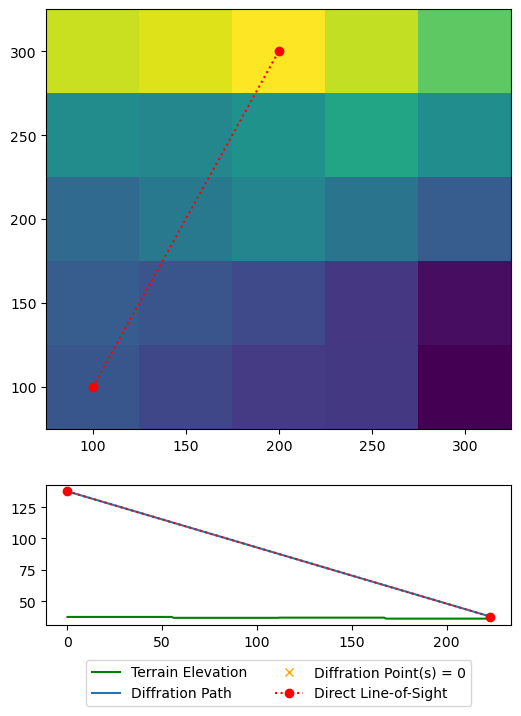

Length, ds:  244.26753558243942


In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

z = np.loadtxt("../../assets/map.txt")[:5, :5]
x0, y0 = 100, 100
x1, y1 = 200, 300
length = np.floor(np.hypot(x1-x0, y1-y0)).astype(int)
x, y = np.linspace(x0, x1, length+1), np.linspace(y0, y1, length+1)

fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (6,8))

map_boundaries = [100, 100, 300, 300]
long_coord = np.linspace(map_boundaries[0], map_boundaries[2], z.shape[1])
lat_coord = np.linspace(map_boundaries[1], map_boundaries[3], z.shape[0])
axes[0].pcolormesh(long_coord, lat_coord, z)
axes[0].plot([x0, x1], [y0, y1], 'ro:')

hs = 100 # source height
hr = 0 # receiver height
xt = np.arange(0, length+1, 1)

boxSize = np.array([map_boundaries[2]- map_boundaries[0], map_boundaries[3]- map_boundaries[1]])
gridsize = np.array(z.shape) - 1

xi = np.floor(((x - min(x)) / boxSize[0]) * gridsize[0])
yi = np.floor(((y - min(y)) / boxSize[1]) * gridsize[1])
yt = z[(xi).astype(int), (yi).astype(int)]

diffraction_index =  calc_diffration(hs, hr, xt, yt)

axes[1].plot(xt, yt, label = "Terrain Elevation", color = "green")
axes[1].plot(*diffraction_index.T, label = "Diffration Path")
axes[1].plot(*diffraction_index[1:-1].T, color = "orange", marker = "x", label = f"Diffration Point(s) = {diffraction_index.shape[0]-2}", linestyle='None')
axes[1].plot([0, length], [yt[0]+hs, yt[-1]+hr], 'ro:', label = "Direct Line-of-Sight")
# plt.legend(loc = "best")
legend = axes[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()


ds = np.hypot(length, np.sum(np.abs(np.diff(diffraction_index[:,1])))) # length of diffraction path
print("Length, ds: ", ds)

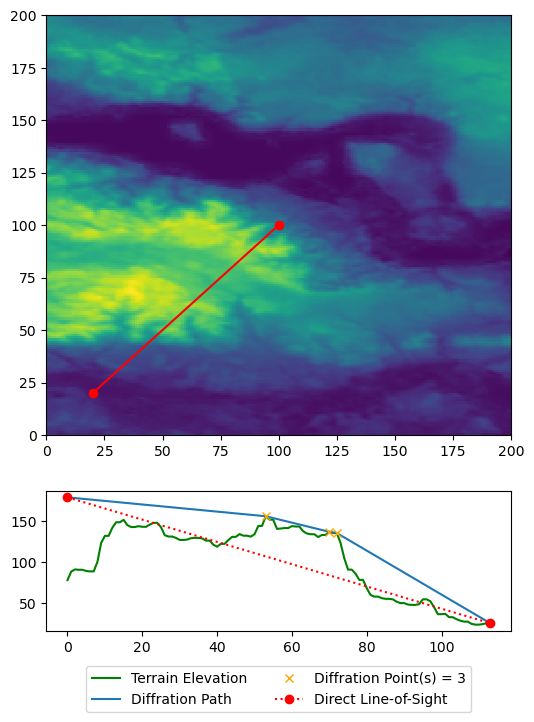

Length, ds:  189.4696721795503


In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

z = np.loadtxt("../../assets/map.txt")
x1, y1 = 20, 20
x0, y0 = 100, 100
length = np.floor(np.hypot(x1-x0, y1-y0)).astype(int)
x, y = np.linspace(x0, x1, length+1), np.linspace(y0, y1, length+1)

fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (6,8))
axes[0].pcolormesh(z)
axes[0].plot([x0, x1], [y0, y1], 'ro-')

hs = 100 # source height
hr = 0 # receiver height
xt = np.arange(0, length+1, 1)
yt = z.T[x.astype(int), y.astype(int)]

diffraction_index =  calc_diffration(hs, hr, xt, yt)

axes[1].plot(xt, yt, label = "Terrain Elevation", color = "green")
axes[1].plot(*diffraction_index.T, label = "Diffration Path")
axes[1].plot(*diffraction_index[1:-1].T, color = "orange", marker = "x", label = f"Diffration Point(s) = {diffraction_index.shape[0]-2}", linestyle='None')
axes[1].plot([0, length], [yt[0]+hs, yt[-1]+hr], 'ro:', label = "Direct Line-of-Sight")
# plt.legend(loc = "best")
legend = axes[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()


ds = np.hypot(length, np.sum(np.abs(np.diff(diffraction_index[:,1])))) # length of diffraction path
print("Length, ds: ", ds)